In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import gensim
from gensim import corpora, models


[nltk_data] Downloading package punkt to /home/victor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/victor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Chargement des données

In [37]:
df = pd.read_csv("../../data/extraction_twint/data_service_clients/wholefoods_computed.csv").filter(["tweet","reply_time"])

#reply time to timedelta
df['reply_time']=df['reply_time'].map(pd.to_timedelta)

#reply time in minutes
df['reply_time']=df['reply_time'].map(lambda x: x.days*1440 + x.seconds//60)

df.head()

,tweet,reply_time
0,#DAM job opening - Senior Marketing Asset Mana...,NaN
1,"Finally, a holiday I can totally support. I'll...",NaN
2,@3rdHourTODAY please mention that there are op...,NaN
3,Thanks for bringing this to our attention. Thi...,NaN
4,"Riddle me this, Whole Foods. How the hell is M...",NaN


# 2. Premières observations

### Proportions de tweets avec/sans réponse

In [5]:
has_reply = df['reply_time'].map(lambda x : not(math.isnan(x)))

#plt.hist(has_reply)
has_reply.value_counts()/has_reply.size*100

False    85.078534
True     14.921466
Name: reply_time, dtype: float64

### Temps de réponse en jours

(array([1.656e+03, 3.940e+02, 1.010e+02, 4.100e+01, 3.900e+01, 1.700e+01,
        7.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 3.000e+00, 3.000e+00,
        4.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
        6.5, 7. , 7.5, 8. , 8.5, 9. , 9.5]),
 <a list of 19 Patch objects>)

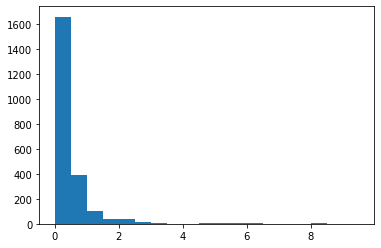

In [6]:
plt.hist(df['reply_time']/1440.0, np.arange(0,10,0.5))

### Temps de réponse en minutes

(array([ 26., 112., 127., 129., 115.,  87.,  87.,  53.,  43.,  29.,  27.,
         31.,  27.,  21.,  21.,  20.,   8.,   8.,   6.,   6.,  10.,   7.,
          9.,  10.,   7.,   5.,   7.,   8.,   6.,   8.,   4.,   6.,   8.,
          7.,   4.,   2.,   3.,   2.,   0.,   5.,   3.,   1.,   3.,   6.,
          1.,   4.,   0.,   0.,   0.,   2.,   2.,   2.,   4.,   2.,   3.,
          3.,   2.,   1.,   1.,   2.,   4.,   2.,   2.,   3.,   2.,   0.,
          0.,   1.,   2.,   1.,   2.,   2.,   2.,   1.,   0.,   4.,   1.,
          3.,   0.,   1.,   2.,   2.,   2.,   2.,   2.,   1.,   1.,   0.,
          3.,   2.,   0.,   0.,   2.,   2.,   0.,   1.,   1.,   0.,   1.,
          1.,   1.,   0.,   0.,   3.,   0.,   1.,   1.,   0.,   2.,   2.,
          0.,   1.,   1.,   2.,   2.,   6.,   4.,   1.,   0.,   1.,   2.,
          2.,   2.,   1.,   1.,   2.,   1.,   1.,   0.,   1.,   2.,   2.,
          1.,   3.,   2.,   0.,   1.,   1.,   0.,   2.,   2.,   1.,   0.,
          1.,   0.,   3.,   2.,   2., 

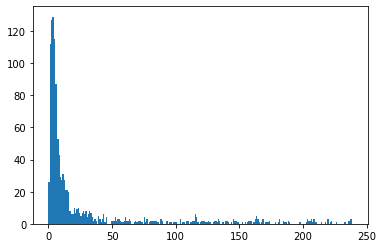

In [7]:
plt.hist(df['reply_time'], np.arange(0,240,1))

# 3. Pré-traitement

In [8]:
sample = df['tweet']

##on enlève les valeurs nulles
sample = sample.dropna()

sample.head()

0    #DAM job opening - Senior Marketing Asset Mana...
1    Finally, a holiday I can totally support. I'll...
2    @3rdHourTODAY please mention that there are op...
3    Thanks for bringing this to our attention. Thi...
4    Riddle me this, Whole Foods. How the hell is M...
Name: tweet, dtype: object

In [9]:
##on tokenise les phrases
sample=sample.map(lambda x: nltk.tokenize.word_tokenize(x))

In [35]:
##liste de stopwords
stop_words = stopwords.words('english')

##on supprime les stopwords
sample = sample.apply(lambda x: [item for item in x if item not in stop_words])
sample.head()

In [12]:
##to be improved or skipped
stemmer = PorterStemmer()

sample=sample.apply(lambda x: [stemmer.stem(item) for item in x])
sample.head(12)

0     [#, dam, job, open, -, senior, market, asset, ...
1     [final, ,, holiday, I, total, support, ., I, '...
2     [@, 3rdhourtoday, pleas, mention, option, hair...
3     [thank, bring, attent, ., thi, valid, offer, '...
4     [riddl, ,, whole, food, ., how, hell, mitch, m...
5     [new, :, enjoy, #, austin, ice, skate, @, whol...
6     [now, decemb, 17, ,, donat, @, wholefood, #, f...
7                                      [So, fake, news]
8     [great, !, usual, reli, fresh, pond, ., ’, fav...
9     [We, call, fresh, pond, locat, inform, us, fro...
10    [discontinu, ?, —i, ’, look, !, look, four, di...
11    [#, givingtuesday, may, -, need, still, strong...
Name: tweet, dtype: object

## 3. Bag of words

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# = TfidfVectorizer(max_features=1000000, token_pattern=r"(?u)\b\w\w+\b|!|\?")
matrix = CountVectorizer(max_features=1000, token_pattern=r"(?u)\b\w\w+\b|!|\?")

X = matrix.fit_transform(df['tweet']).toarray()
X[11]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [18]:
y = has_reply

# split train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [19]:
y[11]

False

In [20]:
# Naive Bayes 
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

# Predict Class
y_pred = classifier.predict(X_test)

# Accuracy 
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

from sklearn.metrics import f1_score
f1_score = f1_score(y_test, y_pred)

In [21]:
print("Accuracy : {}".format(accuracy))
print("F1 score : {}".format(f1_score))

Accuracy : 0.39162303664921466
F1 score : 0.300421432871764


In [22]:
y_pred

array([ True,  True,  True, ...,  True,  True,  True])

In [23]:
y_test

13616    False
4401      True
10346    False
9272     False
1876     False
14693    False
11136    False
14867    False
13966    False
1069     False
15126    False
8946      True
2715     False
6134     False
5836     False
2270     False
4171      True
12959    False
11048    False
14134    False
1810     False
4595     False
1576     False
4295     False
8719     False
4285     False
600      False
8928     False
12158    False
7293     False
         ...  
13986    False
3220      True
14852    False
1875     False
6448     False
9417     False
14826    False
4298     False
8943     False
7526      True
4456     False
1230     False
13345    False
7439     False
57       False
4951      True
10978    False
4492     False
5176     False
11636     True
11081    False
14010    False
574       True
1682     False
3504     False
10717    False
4051      True
8905     False
14007     True
2078     False
Name: reply_time, Length: 3820, dtype: bool

In [31]:
matrix.vocabulary_['?']

20

In [34]:

m = CountVectorizer(max_features=10000, token_pattern=r"(?u)\b\w\w+\b|!|\?")
text=["","bonjour? e je suis victor"]
x = m.fit_transform(text).toarray()
m.vocabulary_

{'bonjour': 1, '?': 0, 'je': 2, 'suis': 3, 'victor': 4}